# Modeling and simulation of complex systems

In [16]:
# 1. Subject: how do you see it? - and Hypothesis
# 2. Model (what kind of model you choose? - can use UML diagram) | Explain the UML and explain what choice did you made? like why virus is an agent and sth like that
# 3. Doc on base model (User documentation of the model)
# 4. Extentions - what did you add to the model (4a, 4b, 4c)
# 5. General conclusion

\break

In [17]:
%config InlineBackend.figure_formats = ['svg']

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

plt.rcParams['font.family'] = 'Latin Modern Roman'

DPI = 800

%matplotlib inline

In [18]:
# import matplotlib

# [f.name for f in matplotlib.font_manager.fontManager.ttflist]

## Introduction

### Requirements and interpretation

This project is for modelling and simulation of a system that involves a forest-pasture ecosystem with goats and sheperds. As a summary, the requirements of the assignment are:

- **Environment description**:

	- Grazing involves sheperds and goats.
	- Dominant tree species: Cormasis gama, forming groves within the pasture.
	- The goats prefer forest (or tree groves) for feeding but grazing reduces forest cover to pasture.

- **Grazing dynamic**:

    - Tree groves can recolonize edge/fringe areas with a monthly probability (0.0025 to 0.02) based on their surrounding abundance.
    - Grazing is shepherd-controlled, influenced by memory and their respect for Forest Department regulations.
    - Grazing season is 10 months; shepherds choose grazing spots based on past experiences and available space.

- **Shepherd behavior and regulation**:

    - Shepherds track forest visibility over the season to set a "self-authorized minimum size" for grove grazing.
    - This individual threshold is recalibrated each season based on the previous season's forest perception.
    - Post-season, the Forest Department sets an "institutional-authorized minimum size" based on shepherd reports, marking smaller groves as protected.

- **Compliance**:

    - Respectful shepherds follow Forest Department's protected grove designations.
    - Disrespectful shepherds ignore regulations, basing decisions solely on personal criteria.

Using these requirements, we can formulate the problem to be more specific, using the following interpretations:

- While the requirements do not mention grass, it is inferred that goats graze on both grass and tree groves in the pasture. In the simulation, we can model this as a goat standing still if it is in a grass cell, and there is no tree grove cell nearby to move to.

- In order to model the growth of the tree, a variable that represents the "amount of tree" available in a grove is needed. A goat will also consume an amount of tree when it grazes on a grove. These numbers can be represented as a ratio of the total amount of tree in a grove, ranging from 0 to 1.

- In order to compare the self-authorised minimum size of the sheperds with the size of the groves, there needs to be a way to compute the grove size as a number of months. To do this, we have to define a growth rate for the tree and the number of months it takes for a tree grove to reach full maturity.

- Tree recolonization can be separated into 2 separate processes:

  + *Seed spreading*: For a seed to be spread to a cell, there needs to be a certain minimum amount of neighboring tree groves adjacent to that cell.

  + *Seed taking root*: Once the requirements for minimum fringe size is met, the seed has a probability of taking root and growing into a tree grove. A minimum probability of 0.0025 is given that corresponds to 1 tree grove adjacent to the cell, and a maximum probability of 0.02 is given that corresponds to 8 tree groves adjacent to the cell.

The methodology of the project is based on building an agent-based model in GAMA to simulate the goat-forest ecosystem, and then to analyze the results of the simulation to understand the dynamics of the system, particularly with respect to the impact of the goat's grazing behavior and the tree's growth and recolonization.

### Hypothesis

To formulate a goal for the project, there are 3 different scenarios that need to be considered:

1. All shepherds were to enter the forest without any regulation, i.e. there is both no self-authorized minimum size and no institutional minimum size.
2. All shepherds were to follow their idea about the minimum size, i.e. the institutional minimum size is completely ignored.
3. All shepherds were to follow the institutional minimum size i.e. the institutional minimum size is strictly followed.

The hypothesis is that:

- The third scenario will result in the best outcome for the forest, as the forest will be protected from overgrazing and the trees will have a chance to recolonize the pasture. 

- The first scenario will result in the worst outcome, as the forest will be overgrazed and the trees will not have a chance to recolonize the pasture. The second scenario will result in an outcome that is better than the first scenario, but worse than the third scenario, as the forest will be overgrazed, while the trees will have a chance to recolonize the pasture. 

However, we might also need to consider the potential impact of a very high forecast coverage, as it might result in a decrease in the pasture area, which might have a negative impact on the goats. As such, batch simulation can be used to test the impact of various parameters on the system, and to optimize for a reasonable level of forest coverage.

### Metrics

From the hypotheis, we can define the following metrics that can be used to analyse and monitor during the simulation:

- **Forest coverage** (percentage): The percentage of the pasture that is covered by trees. A grove is counted towards the forest coverage if it is fully grown. This will be the primary metric to monitor the impact of the sheperd's behavior on the forest.
- **Average self-authorized minimum size** (month): The average size of the forest that the shepherds are willing to graze. This is also the institutional minimum size.
- **Grove size** (month): The size of the forest groves in the pasture, defined as the number of months that the grove has been growing since a seed was planted. We calculate this metric by month to make it possible to compare this with the self-authorized minimum size of the sheperds.


## Model

### Overview

![Overview of the model and its entities](images/model-rls.svg){#fig-model-rls}

In order to set up the simulation, we need to define the following entities:

- Sheperd
- Goat
- Pasture and forest

For each entity, we define them in the sections below, but the general relationship between the entities is shown in @fig-model-rls.

### Environment

#### Global

Several global variables are defined to set up the simulation (@fig-global-class):

- `n_sheperds`: The number of sheperds in the simulation, corresponding to the number of herds.
- `n_goats_per_sheperd`: The number of goats in each herd that a sheperd owns. From this, we can get the total number of goats in the simulation as `n_sheperds * n_goats_per_sheperd`.
- `goat_eating_cap`: The amount of forest that a goat can consume in a cycle (1 month). This is a constant value for all goats in the simulation and is used to simulate the grazing behavior of the goats
- `eating_season_month_end`: The month at which the grazing season ends. For this simulation, we use October (month 10) as the end of the grazing season.
- `n_months_to_full_growth`: The number of months it takes for a tree grove to grow to full size. This value is then used to calculate the growth rate of the groves.
- `min_seed_take_root_proba`: The minimum probability that a seed can take root and start growing. This probability is correspond to a fringe size of 1, and the higher the fringe size, the higher the probability that a seed can take root and start growing.

	$$\text{Actual prob to take root} = \text{min prob to take root} \times \text{actual fringe size}$$

- `min_fringe_size`: The minimum size of a fringe that is required to enable the seed spreading/recolonization of the tree groves. This is however not the only condition for recoonlization, as a seed can only take root based on the probability as defined above.

![Global set up](images/fig-global-class.svg){#fig-global-class}

The simulation is then run for a maximum of 720 months (cycles) before it is stopped.


#### Pasture and Forest

The pasture and tree groves (or forest) are represented as a 2D grid, with each cell representing a unit area of the pasture. Each cell can be either a tree grove or pasture (with grass), and the state of each cell can change over time as the trees grow and the goats graze. This state of change is represented by the color of the cell, ranging from light green (`rgb(144, 238, 144)`) to dark green (`rgb(0, 100, 0)).

Pasture cells are defined in GAMA (@fig-pasture-class) with the following attributes:

- `neighbors`: The number of cells to be considered as neighbors for the cell. We choose 8 neighbors (Moore neighborhood) to represent the fringe area of the groves.

- `fringe`: The list of cells that are considered as the fringe area of the grove, determined by the `neighbors` attribute.

- `tree`: A float value that corresponds to the size of the grove, ranging from 0 to 1. A value of 0 means that the cell is a pasture, and a value of 1 means that the cell is a fully grown grove. Colors of each cell will be determined by this value. When a goat grazes, the goat's grazing capacity is subtracted from the tree value of the cell, leading to the color changing. It is also important to note that due to the grazing dynamic, the tree value of the cell might never reach 0, leading to difficulties in building the logic for the movement and grazing of the goats. As such, we define a threshold of 0.05 to represent a tree-less state so that goats will know when to move and when to eat.

- `current_size`: The size of the grove, defined as the number of months that the grove has been growing since a seed was planted. This value is related to the maximum size of the grove, which is the number of months that the grove will take to reach a fully grown state.

- `color`: The color is changed using the following formula:

	```gaml
	rgb(int(144 * (1 - tree)), int(238 - 138 * tree), int(144 * (1 - tree)))
	```

The pasture cell has the following reflexes (not couning the constructor method):

- `grow_tree`: Every one cycle, the `tree` value is increased by a value of `growth_rate` and the current size is calculated.

- `plant_seed`: If the cell is a pasture with no tree, there is a monthly probability of the cell being recolonized by a seed. The more neighboring cells that are trees, the higher the probability that a seed can spread and take root:

	```gaml
	int nb_tree_count <- fringe count (each.tree = 1.0);
	if nb_tree_count >= min_fringe_size {
		has_tree <- flip(min_spread_seed_proba * nb_tree_count);
	}
	```

![Grid of pasture cells](images/fig-pasture-class.svg){#fig-pasture-class}

::: {#fig-compare-grid layout-ncol=2}
![The pasture grid at cycle 0](images/sheperd_model_display_grid_cycle_0.png){#fig-pasture-grid width="300"}

![Tree groves changing color based on growth](images/sheperd_model_display_grid_cycle_82.png){#fig-pasture-grid width="300"}

Tree groves at cycle 0 and 82. 

:::

### Goat and sheperd

#### Goat species

The goats are the primary agents in the model, as they are responsible for grazing the pasture. There are two main types of goats: respectful and disrespectful, each with a different color (blue and red respectively as shown in @fig-goats). Besides that, if there is no regulation in the simulation, goats will have a different color (purple) to emphasize the neutral nature of the simulation. Goats are set up in GAMA as a species (see @fig-goat-class) with the following attributes:

![Goat species](images/fig-goat-class.svg){#fig-goat-class}

::: {#fig-goats layout-ncol=3}
![Respectful goat](images/respectful_goat.png){#fig-respectful-goat width="140"}

![Disrespectful goat](images/disrespectful_goat.png){#fig-disrespectful-goat width="140"}

![Goat with no regulation](images/neutral_goat.png){#fig-no-reg-goat width="140"}


Colors of the goats based on sheperd behavior.

:::

The goats have 2 main behaviors: grazing and moving. The grazing behavior is responsible for the goats' consumption of the forest, and the moving behavior is responsible for the goats' movement around the pasture. The logic for both behaviors can be illustrated as in @fig-goat-behavior. Here, we can observe that both behaviors are only enabled in the grazing season, and `move` has the opposite logic with `eat_tree`. The model also includes several checks for the abscence of regulation, and the sheperd's attitude towards authority. In general, the algorithm for the goat's behavior when there is some form of regulation in place is:

```pseudo
if (sheperd is respectful) {
	if (grove size > insitutional minimum size) {
		for each goat in herd {
			eat_tree
		}
	} else {
		for each goat in herd {
			move
		}
	}
} else if (sheperd is disrespectful) {
	if (grove size > self-authorized minimum size) {
		for each goat in herd {
			eat_tree
		}
	} else {
		for each goat in herd {
			move
		}
	}
}
```

![Goat's grazing and moving behavior](images/goat-logic.svg){#fig-goat-behavior}

#### Sheperd species

Sheperds are included as a species in the model, however they are not shown in the GUI. Each sheperd owns a herd of goats and has certain tendencies that affect the behavior of the entire herd. The sheperds are set up in GAMA like in @fig-sheperd-class with the following attributes:

- `min_size`: The self-authorized minimum size of the sheperd which is also applied for each goat in the herd.
- `herd_color`: Based on the sheperd's attitude towards authority, the herd will have a different color.
- `goats`: This is the herd of goats that the sheperd owns.
- `is_respectful`: A boolean value that determines if the sheperd is respectful or not.
- `unique_months`: A list of unique months that *at least one goat in the herd* has been able to graze the forest. This is used to calculate the self-authorized minimum size of the sheperd (`min_size`) using the `compute_min_size` reflex.

![Sheperd species](images/fig-sheperd-class.svg){#fig-sheperd-class}

## Analysis

### Simulation

The simulation is run and paused at the 720th month, and with 3 different scenarios. The results of the simulation are then analyzed to understand the impact of the different scenarios on the forest and pasture. @fig-cov-ts shows the time series of the forest coverage for these 3 scenarios.

In [19]:
no_reg = pd.read_csv("../pasture_and_forest/models/results_no_regulation.csv")
respect = pd.read_csv("../pasture_and_forest/models/results_all_respectful.csv")
disrespect = pd.read_csv("../pasture_and_forest/models/results_all_disrespectful.csv")


no_reg["ds"] = pd.to_datetime(no_reg["current_date.year"].astype(str) + "-" + no_reg["current_date.month"].astype(str) + "-1")
respect["ds"] = pd.to_datetime(respect["current_date.year"].astype(str) + "-" + respect["current_date.month"].astype(str) + "-1")
disrespect["ds"] = pd.to_datetime(disrespect["current_date.year"].astype(str) + "-" + disrespect["current_date.month"].astype(str) + "-1")

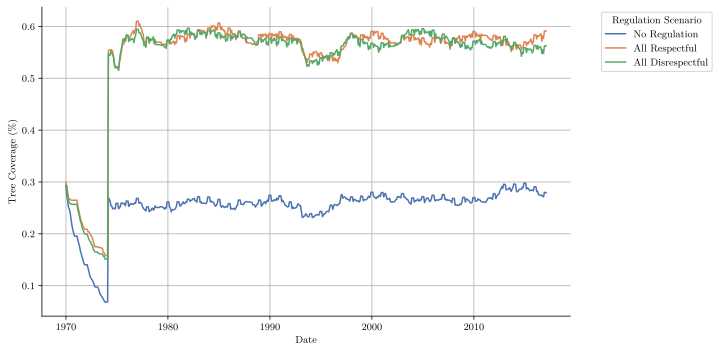

In [20]:
#| label: fig-cov-ts
#| fig-cap: "Tree Coverage by Regulation Scenario over 60 years"


data = pd.DataFrame({
    "Date": no_reg["ds"],
    "No Regulation": no_reg["tree_cov"],
    "All Respectful": respect["tree_cov"],
    "All Disrespectful": disrespect["tree_cov"]
})

data_long = data.melt('Date', var_name='Regulation', value_name='Tree Coverage')

plt.figure(figsize=(12, 5), dpi=DPI)
chart = sns.lineplot(data=data_long, x='Date', y='Tree Coverage', hue='Regulation', palette='deep')

# plt.title('Tree Coverage Over Time by Regulation Scenario', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Tree Coverage (%)')
# plt.xticks(rotation=45)

plt.legend(title='Regulation Scenario', loc='upper left', bbox_to_anchor=(1.05, 1))

sns.despine()
plt.grid()
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

@tbl-avg-cov also shows the average forest coverage over time for these 3 scenarios. From both this data and @fig-cov-ts, we can see that:

- Forest coverage is the highest when there is no regulation at all: This is a reasonable outcome, since the goats are free to roam and graze as they please, and the trees are not protected from overgrazing.
- Forest coverage is the lowest when the sheperds are respectful i.e. they strictly follow the institutional minimum size: This is also a reasonable outcome, since the trees are protected from overgrazing with a global minimum size. However, the tree coverage in this scenario is not much higher than the **disrespectful** scenario where all sheperds ignore the regulations. This is likely because the global minimum size is simply an average of the self-authorized minimum size, and does not have a significant impact on the forest coverage.

In [21]:
#| label: tbl-avg-cov
#| tbl-cap: "Average Tree Coverage by Regulation Scenario over 60 years"


pd.DataFrame({
	"Scenario": ["There is no Regulation", "All sheperds are disrespectful", "All sheperds are respectful"],
	"Avg. Tree Coverage": [no_reg["tree_cov"].mean(), disrespect["tree_cov"].mean(), respect["tree_cov"].mean()]
})

,Scenario,Avg. Tree Coverage
0,There is no Regulation,0.252454
1,All sheperds are disrespectful,0.543203
2,All sheperds are respectful,0.547726


### Calibration

In an ecosystem like this where there are different agents and entities interacting with each other, it can be useful to explore the impact of different parameters on the system. With GAMA, we can set up the optimization experiment with the following configuration:

- **Objective function**: To minimize the absolute difference between the forest coverage and 0.6, i.e. to find the parameters that result in a forest coverage of 0.6. This is to mimic the real-world scenario where a healthy forest coverage is desired, but an excessive forest coverage might have a negative impact on the pasture area and the goat population, and by extension, the human population that depends on the goats for food and income.
- **Optimization method**: We use the Tabu Search algorithm [@gama] with:
	- `iter_max`: 10
	- `tabu_list_size`: 3
- **Parameter search space** (these are the parameters that have potential impact on the system): as shown in @tbl-param.

In [22]:
#| label: tbl-param
#| tbl-cap: "Parameter Space"

pd.DataFrame({
	"Parameter": ["The probability of tree recolonization", "The grazing capacity of the goats", "The number of respectful sheperds"],
	"Max": [0.125, 1.0, 10],
	"Min": [0.0005, 0.1, 0]
})

,Parameter,Max,Min
0,The probability of tree recolonization,0.125,0.0005
1,The grazing capacity of the goats,1.000,0.1000
2,The number of respectful sheperds,10.000,0.0000


As for the probability of tree recolonization (or seed spreading and taking root): This is the minimum probability in the case that there is only one neighboring tree grove in the 8 neighboring cells. As such, the maximum probability is 8 times the minimum probability, i.e. 0.004 to 1.0.

Using these parameters, we can set up the optimization experiment to find the parameters that result in a forest coverage that is closest to 0.6. The results of the calibration is shown in @tbl-optim.

In [23]:
#| label: tbl-optim
#| tbl-cap: "Optimization results"

calib_result = pd.read_csv("../pasture_and_forest/models/optim.csv")

calib_result.assign(diff=0.6 - calib_result["tree_cov"]).query("diff < 0.01")[["tree_cov", "n_respectful_sheperd", "goat_eating_cap", "min_spread_seed_proba"]].drop_duplicates().rename(columns={"tree_cov": "Tree Cov.", "n_respectful_sheperd": "No. of Respectful Sheperds", "goat_eating_cap": "Grazing Capacity", "min_spread_seed_proba": "Min Seed Spreading Prob."}).sort_values("Tree Cov.", ascending=False).reset_index(drop=True)

,Tree Cov.,No. of Respectful Sheperds,Grazing Capacity,Min Seed Spreading Prob.
0,0.6080,10,0.4,0.0065
1,0.6080,10,0.4,0.0070
2,0.6080,10,0.4,0.0075
3,0.5996,8,0.4,0.0065
4,0.5996,8,0.4,0.0075


### Discussion

The model and simulation, while simple, can be used to understand the dynamics of the real-world system. Specifically, with the results of the simulation, several conclusions can be drawn:

- The forest coverage is higher when there is regulation in place, either from an institution or from the sheperds themselves. However, forest coverage can also be improved by changing the probability of tree recolonization. In a real-world scenario, this might be achieved by planting more trees, or by changing the environment (through controlled burns, for example) to make it more conducive for trees to grow.

- In the calibration experiment, the goat's grazing capacity tend to have an effect on the forest coverage. In the real world, this might be difficult to control since changing a goat's diet might have a negative impact on the goat's health. However, it might be possible to control the goat's population, or to introduce guiding schemes that control the goat's movement and grazing behavior, e.g. with sheperd dogs and fences.

## Conclusion

In this project, we have built an agent-based model using the GAMA Platform to simulate a forest-pasture ecosystem with goats and sheperds. The model is then used to analyze the impact of different scenarios on the forest and pasture, and to calibrate the parameters of the model to find the parameters that result in a forest coverage that is closest to 0.6. 

On the other hand, there are point of improvements and extensions that can be made to the model:

- **Herd behavior**: In the real world, goats in the same herd tend to follow a dominant goat that is responsible for leading the herd to the best grazing areas [@cornell]. If the dominant goat is taken out of the herd, the other goats will show confusion until another dominant goat (often called the "queen") is chosen.

- **Introducing other agents**: In the real world, there are other agents that might have an impact on the system, such as predators that might prey on the goats. This can be introduced to the model to understand the impact of predators on the system. In fact, the presence of predators might have a positive impact on the forest, such as wolves which are usually called "keystone species" in the ecosystem [@asu].

- **Modify the terrain**: The model can be modified to include different types of terrain, such as hills and rivers, which might have an impact on the movement of the goats and the growth of the trees. In reality, goats tend to prefer foraging on rough and steep land over flat, smooth land [@ncsu].

In terms of the analysis and calibration, several other parameters can be explored:

- The perceiving range of the goat
- The growth rate of the trees / the amount of time in months that it takes for a grove to grow fully


## References

::: {#refs}
:::